# Use RAPIDS on a GPU Cluster


![DASKLogo](https://saturn-public-assets.s3.us-east-2.amazonaws.com/example-resources/dask.png)![RAPIDS Logo](https://saturn-public-assets.s3.us-east-2.amazonaws.com/example-resources/rapids.png)

RAPIDS is a collection of libraries that enable you to take advantage of NVIDIA GPUs to accelerate machine learning workflows. Minimal changes are required to transition from familiar `pandas` and `scikit-learn` code!

## Overview
This example describes how to run a machine learning training workflow using the famous NYC Taxi Dataset. This dataset contains information about taxi trips in New York City. For the purposes of this example, we will be looking at the Yellow Taxi data from 2019.
We will use this data to answer the following question:
> Based on characteristics that can be known at the beginning of a trip, will this trip result in a good tip?

This exercise uses the following RAPIDS packages to execute code on a Dask cluster of GPU workers:

* [`dask-cudf`](https://docs.rapids.ai/api/cudf/stable/dask-cudf.html): distributed `cudf` dataframes using Dask
* [`cuml`](https://github.com/rapidsai/cuml): machine learning training and evaluation, similar to `scikit-learn`

For more information on RAPIDS, see ["Getting Started"](https://rapids.ai/start.html) in the RAPIDS docs.

## Modeling Process

### Imports

In [1]:
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dask.distributed import Client, wait
from dask_saturn import SaturnCluster

import dask_cudf

from cuml.dask.ensemble import RandomForestClassifier

from cuml.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

### Set Up Your Saturn Cloud Environment
The easiest way to get started with this example is to use the RAPIDS template resource. Log on to your Saturn Cloud account and click on the RAPIDS template on the main screen. Then just start the Jupyter Server, Dask Cluster, and run Jupyter Lab.

If you want to create a custom resource, use the `saturncloud/saturn-rapids` image to get started.

### Start the Dask Cluster

The template resource you are running has a Dask cluster already attached to it with three workers. The `dask-saturn` code below creates two important objects: a cluster and a client.

* `cluster`: knows about and manages the scheduler and workers
    - can be used to create, resize, reconfigure, or destroy those resources
    - knows how to communicate with the scheduler, and where to find logs and diagnostic dashboards
* `client`: tells the cluster to do things
    - can send work to the cluster
    - can restart all the worker processes
    - can send data to the cluster or pull data back from the cluster

In [3]:
n_workers = 3
cluster = SaturnCluster(n_workers=n_workers)
client = Client(cluster)

INFO:dask-saturn:Cluster is ready
INFO:dask-saturn:Registering default plugins
INFO:dask-saturn:Success!


If you already started the Dask cluster on the resource page, then the code above will run much more quickly since it will not have to wait for the cluster to turn on.

>**Pro tip**: Create start the cluster in the Saturn UI before opening JupyterLab if you want to get a head start!

The last command ensures the kernel waits until all of the desired workers are online before continuing:

In [4]:
client.wait_for_workers(n_workers=n_workers)

### Download the Dataset

The first thing we want to do is load in the NYC Taxi Trip dataset. The code below loads the data into a `dask-cudf` data frame. You can interact with this data structure as if it was just a regular `cudf` data frame, but it is actually a collection of smaller `cudf` data frames spread across the workers in the Dask cluster.

A `cudf` data frame is similar to a `pandas` data frame, but it lives in GPU memory and most operations on it are done on the GPU.

In [12]:
taxi = dask_cudf.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2019-01.csv",
    parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    storage_options={"anon": True},
    assume_missing=True,
).persist()

wait(taxi)

DoneAndNotDoneFutures(done={<Future: finished, type: cudf.DataFrame, key: ('read-csv-1881c555a18b1ff5b64c692821a92084', 2)>, <Future: finished, type: cudf.DataFrame, key: ('read-csv-1881c555a18b1ff5b64c692821a92084', 0)>, <Future: finished, type: cudf.DataFrame, key: ('read-csv-1881c555a18b1ff5b64c692821a92084', 1)>}, not_done=set())

- `parse_dates` tells `dask-cudf` to interpret the "tpep_pickup_datetime", "tpep_dropoff_datetime" columns in the datasets as datetime columns. 
- `storage_options` tells `s3` to use anonomous credentials. 
- `assume_missing` makes Dask assume that columns inferred to be int (which don’t allow missing values) are actually floats (which do allow missing values).
- `persist()` tells Dask to keep the data in distributed memory so that you don't need to recompute the computation a second time.

### Do Analysis on the Raw Data

Many dataframe operations that you would execute on a `pandas` dataframe also work for a `dask-cudf` dataframe.

> Simple commands might take longer than you are used to. This is due to the distributed nature of the dataframe.

You can view the first 10 rows of the data using the `.head()` command.

In [13]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2019-01-01 00:46:40,2019-01-01 00:53:20,1.0,1.5,1.0,N,151.0,239.0,1.0,7.0,0.5,0.5,1.65,0.0,0.3,9.95,<NA>
1,1.0,2019-01-01 00:59:47,2019-01-01 01:18:59,1.0,2.6,1.0,N,239.0,246.0,1.0,14.0,0.5,0.5,1.00,0.0,0.3,16.30,<NA>
2,2.0,2018-12-21 13:48:30,2018-12-21 13:52:40,3.0,0.0,1.0,N,236.0,236.0,1.0,4.5,0.5,0.5,0.00,0.0,0.3,5.80,<NA>
3,2.0,2018-11-28 15:52:25,2018-11-28 15:55:45,5.0,0.0,1.0,N,193.0,193.0,2.0,3.5,0.5,0.5,0.00,0.0,0.3,7.55,<NA>
4,2.0,2018-11-28 15:56:57,2018-11-28 15:58:33,5.0,0.0,2.0,N,193.0,193.0,2.0,52.0,0.0,0.5,0.00,0.0,0.3,55.55,<NA>


You can see the datatypes of the data using the `.dtypes` command.

In [14]:
taxi.dtypes

VendorID                        float64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                    float64
DOLocationID                    float64
payment_type                    float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

You can compute the length and memory usage of the dataset using the following code.

>Dask is lazily evaluated. The result from a computation is not computed until you ask for it. Instead, a Dask task graph for the computation is produced. Anytime you have a Dask object and you want to get the result, call `compute`.

In [15]:
num_rows = len(taxi)
memory_usage = taxi.memory_usage(deep=True).sum().compute() / 1e9
print(f"Num rows: {num_rows}, Memory Usage: {memory_usage} GB")

Num rows: 7667792, Memory Usage: 1.082117276 GB


When we say that a `dask-cudf` dataframe is a *distributed* data frame, that means that it comprises multiple smaller `cudf` data frames. Run the following to see how many of these pieces (called "partitions") there are.

In [16]:
taxi.npartitions

3

### Preprocess the Data
The raw data we downloaded needs to be processed before we can use it to train our machine learning model. We need to do things like create a target column, add additional features, and remove columns that we do not need. We will wrap everything in a function so we can use it later when we need to prepare data for testing or implementation.

Notice that this code looks identical to the code you ran in the [single-node RAPIDS example](rapids-single-gpu.ipynb). `dask-cudf` translates regular `cudf` operations into the corresponding distributed operations.

In [18]:
def prep_df(df: dask_cudf.DataFrame) -> dask_cudf.DataFrame:
    
    df = df[df['fare_amount'] > 0] #to avoid a divide by zero error
    df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
    df['target'] = df['tip_fraction'] > 0.2

    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_week_hour'] = (df['pickup_weekday'] * 24) + df.pickup_hour
    df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
    
    df = df[['pickup_weekday',
             'pickup_hour',
             'pickup_week_hour',
             'pickup_minute',
             'passenger_count',
             'PULocationID',
             'DOLocationID',
             'target'
            ]]
    
    df = df.astype('float32').fillna(-1)
    df['target'] = df['target'].astype('int32')

    return df

The function does the following:

|||
|---|---|
|**Creates a target column**|The raw data don't contain a column that cleanly describes whether a particular ride could be considered a "good" tip. So we need to add one! In this exercise, a "good" tip is one that is greater than 20% of the fare amount. This function makes this a binary classification problem.|
|**Adds additional features**|Here, instead of giving a model a raw timestamp, we provide multiple derived characteristics like hour of the day and day of the week. Giving the machine learning model a richer description of each training observation improves its ability to describe the relationship between those observations' characteristics and the target. |
|**Removes Unused Columns**|If the goal is to produce a model that could predict whether a tip will be good *at the beginning of the trip*, then characteristics that can only be known **AFTER** the tip must be excluded. For example, you can't know the dropoff time or the type of payment until a ride has concluded.|
|**Cast the Columns to 32-bit types**|This reduces the memory footprint of the model and insures compatablility with older version of `cuml`.

We now just need to run the raw data through our function to prepare it for machine learning.


In [19]:
taxi = prep_df(taxi)

### Do Analysis on the Preprocessed Data

Since this is a binary classification task, before proceeding we should examine the proportion of 1s and 0s in the target. This can be done with the `value_counts()` method.


In [21]:
taxi['target'].value_counts(normalize = True).compute()

1    0.522546
0    0.477454
Name: target, dtype: float64

We should also check the first few rows of the dataset using the `.head()` function to make sure that the features look reasonable.

In [22]:
taxi.head()

,pickup_weekday,pickup_hour,pickup_week_hour,pickup_minute,passenger_count,PULocationID,DOLocationID,target
0,1.0,0.0,24.0,46.0,1.0,151.0,239.0,1
1,1.0,0.0,24.0,59.0,1.0,239.0,246.0,0
2,4.0,13.0,109.0,48.0,3.0,236.0,236.0,0
3,2.0,15.0,63.0,52.0,5.0,193.0,193.0,0
4,2.0,15.0,63.0,56.0,5.0,193.0,193.0,0


Now that the dataframe has been processed, let’s check its length and size in memory again.

In [25]:
num_rows = len(taxi)
memory_usage = taxi.memory_usage(deep=True).sum().compute() / 1e9
print(f"Num rows: {num_rows}, Memory Usage: {memory_usage} GB")

Num rows: 7658235, Memory Usage: 0.3063294 GB


Removing unused columns dropped the size of the training data to about one-third the size of the raw data. You can also see that the dataset lost a few rows with zero fare amounts.

### Train a Random Forest Model

Now that the data has been prepped, it’s time to build a model!

For this task, we'll use the `RandomForestClassifier` from `cuml`. If you've never used a random forest or need a refresher, consult ["Forests of randomized trees"](https://scikit-learn.org/stable/modules/ensemble.html#forest) in the `scikit-learn` documentation.

First, we define the X and y variables for the model.

In [26]:
X = taxi.drop(columns = ['target'])
y = taxi['target']

Next, we define the model with the following parameters:
- `n_estimators=100` = create a 100-tree forest
- `max_depth=10` = stop growing a tree once it contains a leaf node that is 10 levels below the root
- `n_streams` - create four decision trees at a time

In [27]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, n_streams=4)

Changing any of these parameters will change the training time, memory requirements, and model accuracy. Feel free to play around with these parameters!

And, finally, we train the model.

In [28]:
%%time
_ = rfc.fit(X, y)

CPU times: user 64.4 ms, sys: 2.95 ms, total: 67.3 ms
Wall time: 7.1 s


This should take about 8 seconds to run. The `%%time` command before the function prints out exactly how long it takes to train.

### Calculate Metrics on a Test Set 

We will use another month of taxi data for the test set and calculate the AUC score.

In [33]:
taxi_test = dask_cudf.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2019-02.csv",
    parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    storage_options={"anon": True},
    assume_missing=True,
).persist()

wait(taxi_test)

DoneAndNotDoneFutures(done={<Future: finished, type: cudf.DataFrame, key: ('read-csv-e71ca7fe5855ba1c45cad147fd3a69cd', 0)>, <Future: finished, type: cudf.DataFrame, key: ('read-csv-e71ca7fe5855ba1c45cad147fd3a69cd', 1)>, <Future: finished, type: cudf.DataFrame, key: ('read-csv-e71ca7fe5855ba1c45cad147fd3a69cd', 2)>}, not_done=set())

Before creating predictions on this new dataset, it has to be transformed in exactly the way that the original training data were prepared. Thankfully you have already wrapped that transformation logic in a function!

In [34]:
taxi_test = prep_df(taxi_test)

`cuml` comes with many functions for calculating metrics that describe how well a model's predictions match the actual values. This tutorial uses the `roc_auc_score()` to evaluate the model. This metric measures the area under the receiver operating characteristic curve. Values closer to 1.0 are desirable.

In [35]:
X_test = taxi_test.drop(columns = ['target'])
y_test = taxi_test['target']

preds = rfc.predict_proba(X_test)[1]

As of this writing, `cuml.metrics.roc_auc_score` does not support Dask collections as inputs. The code below uses `.compute()` to create numpy arrays instead. This isn't ideal because it means that the amount of data you can score on is limited by the size of the instance you're running this code on. Hopefully support for Dask collections will be added in a future verison of `cuml`.

In [36]:
y_test = y_test.compute()
preds = preds.compute()

In [37]:
roc_auc_score(y_test, preds)

0.5658248066902161

### Graph the ROC Curve

Finally, let’s look at the ROC curve. `cuml` does not have a ROC curve function, so we convert the target column and predictions to `numpy` arrays and use the `sklearn` `roc_curve` function. Plotting is done by the `seaborne` library.

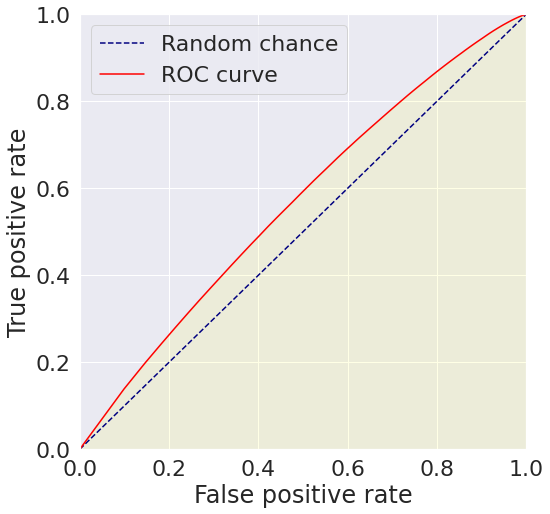

In [46]:
fpr, tpr, _ = roc_curve(y_test.to_array(), preds.to_array())
    
sns.set(font_scale = 2)
fig = plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.plot(fpr,tpr , color='red')
plt.legend(['Random chance','ROC curve'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([0,1])
plt.ylim([0,1])
plt.fill_between(fpr,tpr, color='yellow', alpha=0.1)
plt.show()

The graph shows that our results were only moderately better than random chance. It is possible that tuning hyperparameters and giving the model additional features and training data will improve this outcome.

## Conclusion
In this example, we showed how to use the RAPIDS library with a GPU cluster to train a model for a binary classification task. We [downloaded data from s3](ref), preprocessed the data, ran the model, tested the model, and calculated and plotted the accuracy. See our other RAPIDS tutorial for how you can do the same problem [using a single GPU](./rapids-single-gpu.ipynb)!
